In [10]:
import pandas as pd

dataset1=pd.read_csv("data/en_bn.csv")
dataset2=pd.read_csv("data/english_to_bangla.csv")

In [11]:
dataset1.head()

,en_text,bn_text
0,"Hello, good to see you!","হ্যালো, আপনাকে দেখে ভালো লাগলো!"
1,"Goodbye, have a great day!","বিদায়, আপনার দিন শুভ হোক!"
2,Thank you very much for your help.,আপনার সহায়তার জন্য অনেক ধন্যবাদ।
3,I appreciate it.,আমি এটি প্রশংসা করি।
4,You're welcome!,আপনার স্বাগতম!


In [12]:
dataset2.head()

,en,bn
0,a child in a pink dress is climbing up a set o...,একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...
1,a girl going into a wooden building .,একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে
2,a little girl climbing into a wooden playhouse .,একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে ।
3,a little girl climbing the stairs to her playh...,ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে
4,a little girl in a pink dress going into a woo...,গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...


In [13]:
dataset1.shape, dataset2.shape

((120000, 2), (39065, 2))

In [14]:
dataset1.rename(columns={"en_text":"english","bn_text":"bangla"}, inplace=True)
dataset2.rename(columns={"en":"english","bn":"bangla"}, inplace=True)

In [15]:
full_dataset=pd.concat([dataset1,dataset2], ignore_index=True)
full_dataset.head()

,english,bangla
0,"Hello, good to see you!","হ্যালো, আপনাকে দেখে ভালো লাগলো!"
1,"Goodbye, have a great day!","বিদায়, আপনার দিন শুভ হোক!"
2,Thank you very much for your help.,আপনার সহায়তার জন্য অনেক ধন্যবাদ।
3,I appreciate it.,আমি এটি প্রশংসা করি।
4,You're welcome!,আপনার স্বাগতম!


In [16]:
full_dataset.shape

(159065, 2)

In [47]:
full_dataset.to_csv("data/english_bangla_translation.csv", index=False)

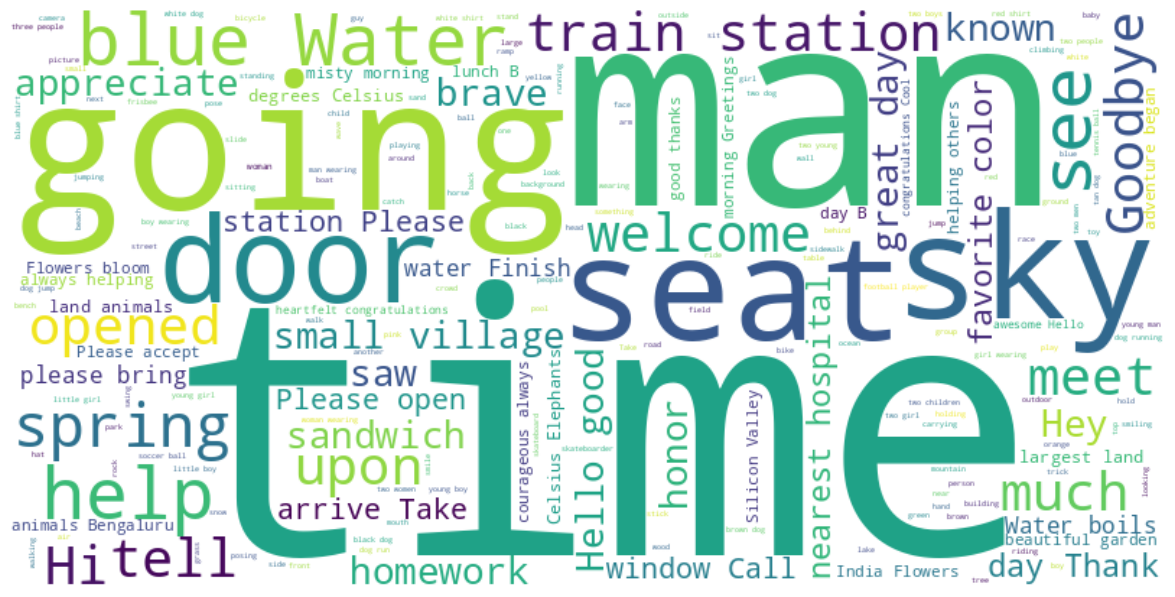

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

english_text = ' '.join(full_dataset['english'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(english_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

# Vocabulary building for Language Translation

How counter keeps track of word frequencies

In [34]:
from collections import Counter
counter = Counter()

for i in range(1,10):
    counter.update("Hello I am fine".split())

In [35]:
counter.most_common(10)

[('Hello', 9), ('I', 9), ('am', 9), ('fine', 9)]

In [22]:
from collections import Counter

def tokenize(text):
    return text.strip().split() 

SPECIAL_TOKENS = ["<pad>", "<sos>", "<eos>", "<unk>"]

def build_vocab(sentences, min_freq=1):
    counter = Counter()
    for s in sentences:
        counter.update(tokenize(str(s)))

    vocab = {tok: idx for idx, tok in enumerate(SPECIAL_TOKENS)} # add the special tokens first with reserved indices
    for token, freq in counter.items():
        if freq >= min_freq and token not in vocab:
            vocab[token] = len(vocab)
    idx2word = {idx: tok for tok, idx in vocab.items()}
    return vocab, idx2word

In [23]:
source_sentences = full_dataset['english'].astype(str).tolist()
target_sentences = full_dataset['bangla'].astype(str).tolist()

target_sentences = full_dataset['bangla'].astype(str).tolist()

src_vocab, src_idx2word = build_vocab(source_sentences)
tgt_vocab, tgt_idx2word = build_vocab(target_sentences)

len(src_vocab), len(tgt_vocab)

(8919, 17407)

# Transformer Architecture

In [36]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self,embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads  # Integer division to ensure head_dim is an integer
        
        assert (self.head_dim * heads == embed_size),  "Embedding size needs to be divisible by heads"
        
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)
        
    def forward(self, values, keys, query, mask):
        N = query.shape[0] # Number of examples in the batch
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        
        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)
        
        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)        # (N, key_len, heads, head_dim)
        queries = self.queries(queries)  # (N, query_len, heads, head_dim)
        
        # Einsum does batch matrix multiplication for query*keys for each training example
        # we have query shape: (N, query_len, heads, head_dim) and key shape: (N, key_len, heads, head_dim)
        # we want to multiply the metrics in the way where n is batch size, h is heads, q is query_len and k is key_len
        # finally we get energy shape: (N, heads, query_len, key_len) = nhqk 
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)  # Normalize on the last axis (key_len)
        
        out = torch.einsum("nhqk,nkhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        
        out = self.fc_out(out)
        
        return out

## Self-Attention (Deep Dive with an Intuitive Example)

Self-attention lets each token **look at every other token** in the sequence and decide how much each other token should influence its representation. It does this by creating three vectors for every token: **Query (Q)**, **Key (K)**, and **Value (V)**.

### Intuition with a simple example

Sentence: **“the animal didn’t cross the street because it was tired.”**

The word **“it”** could refer to *animal* or *street*. Self-attention helps the model figure out it refers to **animal** by assigning higher attention weight from **“it”** to **“animal”** than to **“street.”**

So, the representation of **“it”** becomes a weighted mix of other words, mostly influenced by **“animal.”**

---
### What happens mathematically
1. **Embed tokens** into vectors (size = $d_{model}$).
2. **Project each embedding into Q, K, V** with learned matrices.
   $$Q = XW_Q,\quad K = XW_K,\quad V = XW_V$$
3. **Compute similarity scores** between each query and all keys:
   $$\text{score}(i, j) = \frac{Q_i \cdot K_j}{\sqrt{d_k}}$$
4. **Mask (optional)** future tokens (decoder) or padding tokens.
5. **Softmax** to turn scores into probabilities:
   $$\alpha_{i,j} = \text{softmax}(\text{score}(i, j))$$
6. **Weighted sum of values** gives new token representation:
   $$\text{Attention}(Q, K, V) = \alpha V$$

---
### How this maps to your `SelfAttention` code
Your block does the same steps:
- Splits embeddings into multiple heads (`self.heads`)
- Projects into Q/K/V using `nn.Linear`
- Uses `einsum` to compute similarity
- Applies softmax to get attention weights
- Mixes values back and concatenates heads

---
### Why multiple heads?
Multiple heads let the model **attend to different relationships** at the same time.
For example:
- Head 1 might connect **pronouns → nouns**
- Head 2 might capture **verb-object relations**
- Head 3 might focus on **local word order**

In [37]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        
        # Add & Norm
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        
        # Add & Norm
        out = self.dropout(self.norm2(forward + x))
        return out


In [43]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            out = layer(out, out, out, mask)
        
        return out


In [44]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

In [45]:
class Decoder(nn.Module):
    def __init__(
        self,
        tgt_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        
        self.fc_out = nn.Linear(embed_size, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
        
        out = self.fc_out(x)
        
        return out

In [46]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        src_pad_idx,
        tgt_pad_idx,
        embed_size=256,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cuda",
        max_length=100,
    ):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )
        
        self.decoder = Decoder(
            tgt_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )
        
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)
    
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

## Dataset Preparation & DataLoader

Now we'll prepare the dataset and create PyTorch DataLoaders for batch training.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import random

# Convert sentences to token IDs
def encode_sentence(sentence, vocab, max_len=50):
    tokens = tokenize(str(sentence))
    ids = [vocab.get(tok, vocab["<unk>"]) for tok in tokens]
    
    # Add start token
    ids = [vocab["<sos>"]] + ids
    
    # Truncate or pad
    if len(ids) > max_len - 1:
        ids = ids[:max_len - 1]
    
    # Add end token
    ids = ids + [vocab["<eos>"]]
    
    # Pad to max_len
    if len(ids) < max_len:
        ids = ids + [vocab["<pad>"]] * (max_len - len(ids))
    
    return ids[:max_len]

# Create parallel dataset
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_len=50):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.src_sentences)
    
    def __getitem__(self, idx):
        src = encode_sentence(self.src_sentences[idx], self.src_vocab, self.max_len)
        tgt = encode_sentence(self.tgt_sentences[idx], self.tgt_vocab, self.max_len)
        
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

# Create dataset and dataloaders
MAX_LEN = 50
BATCH_SIZE = 32

# Train-val split
data_size = len(source_sentences)
indices = list(range(data_size))
random.shuffle(indices)
train_split = int(0.9 * data_size)

train_indices = indices[:train_split]
val_indices = indices[train_split:]

train_src = [source_sentences[i] for i in train_indices]
train_tgt = [target_sentences[i] for i in train_indices]
val_src = [source_sentences[i] for i in val_indices]
val_tgt = [target_sentences[i] for i in val_indices]

# Create datasets
train_dataset = TranslationDataset(train_src, train_tgt, src_vocab, tgt_vocab, MAX_LEN)
val_dataset = TranslationDataset(val_src, val_tgt, src_vocab, tgt_vocab, MAX_LEN)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

## Model Initialization & Training Setup

Initialize the Transformer model, optimizer, and loss function.

In [ ]:
import torch.optim as optim

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Hyperparameters
embed_size = 256
num_layers = 4
forward_expansion = 4
heads = 8
dropout = 0.1
learning_rate = 3e-4
num_epochs = 10

# Initialize model
model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    src_pad_idx=src_vocab["<pad>"],
    tgt_pad_idx=tgt_vocab["<pad>"],
    embed_size=embed_size,
    num_layers=num_layers,
    forward_expansion=forward_expansion,
    heads=heads,
    dropout=dropout,
    device=device,
    max_length=MAX_LEN,
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nModel initialized with:")
print(f"  Source vocab size: {len(src_vocab)}")
print(f"  Target vocab size: {len(tgt_vocab)}")
print(f"  Embedding size: {embed_size}")
print(f"  Num layers: {num_layers}")
print(f"  Num heads: {heads}")

## Training Loop

Train the Transformer model on the dataset.

In [ ]:
from tqdm import tqdm

def train_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    
    for idx, (src, trg) in enumerate(tqdm(iterator)):
        src = src.to(device)
        trg = trg.to(device)
        
        # Forward pass
        output = model(src, trg[:, :-1])  # Exclude last token from decoder input
        
        # Reshape for loss computation
        output = output.reshape(-1, output.shape[2])
        trg = trg[:, 1:].reshape(-1)  # Exclude first token (start token)
        
        # Backward pass
        optimizer.zero_grad()
        loss = criterion(output, trg)
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        if (idx + 1) % 50 == 0:
            print(f"  Batch {idx + 1}/{len(iterator)} - Loss: {loss.item():.4f}")
    
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for src, trg in tqdm(iterator):
            src = src.to(device)
            trg = trg.to(device)
            
            output = model(src, trg[:, :-1])
            
            output = output.reshape(-1, output.shape[2])
            trg = trg[:, 1:].reshape(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

print("\n✓ Training complete!")

## Visualization of Training Progress

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")

## Inference / Translation Function

Generate translations using the trained model.

In [ ]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, src_idx2word, tgt_idx2word, device, max_len=50):
    """
    Translate a sentence from source language to target language.
    """
    model.eval()
    
    # Encode source sentence
    tokens = tokenize(str(sentence))
    src_ids = [src_vocab["<sos>"]] + [src_vocab.get(tok, src_vocab["<unk>"]) for tok in tokens]
    
    if len(src_ids) > max_len - 1:
        src_ids = src_ids[:max_len - 1]
    
    src_ids = src_ids + [src_vocab["<eos>"]]
    
    if len(src_ids) < max_len:
        src_ids = src_ids + [src_vocab["<pad>"]] * (max_len - len(src_ids))
    
    src_tensor = torch.tensor(src_ids[:max_len], dtype=torch.long).unsqueeze(0).to(device)
    
    # Start with target start token
    tgt_ids = [tgt_vocab["<sos>"]]
    tgt_tensor = torch.tensor(tgt_ids, dtype=torch.long).unsqueeze(0).to(device)
    
    # Pad tgt_tensor to max_len
    while tgt_tensor.shape[1] < max_len:
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor)
        
        # Get the last predicted token
        next_token_id = output[0, -1, :].argmax(dim=-1).item()
        
        # If EOS token or max length reached, stop
        if next_token_id == tgt_vocab["<eos>"] or tgt_tensor.shape[1] >= max_len:
            break
        
        # Add predicted token
        tgt_ids.append(next_token_id)
        tgt_tensor = torch.tensor(tgt_ids, dtype=torch.long).unsqueeze(0).to(device)
        
        # Pad to max_len
        if tgt_tensor.shape[1] < max_len:
            padding = torch.full((1, max_len - tgt_tensor.shape[1]), tgt_vocab["<pad>"], dtype=torch.long).to(device)
            tgt_tensor = torch.cat([tgt_tensor, padding], dim=1)
    
    # Decode target IDs to words
    translated_tokens = []
    for token_id in tgt_ids[1:]:  # Skip start token
        if token_id == tgt_vocab["<eos>"]:
            break
        if token_id != tgt_vocab["<pad>"]:
            translated_tokens.append(tgt_idx2word.get(token_id, "<unk>"))
    
    return " ".join(translated_tokens)

# Test translation on a few examples
print("=" * 80)
print("TRANSLATION EXAMPLES")
print("=" * 80)

test_sentences = [
    full_dataset['english'].iloc[0],
    full_dataset['english'].iloc[100],
    full_dataset['english'].iloc[500],
]

for idx, sentence in enumerate(test_sentences, 1):
    translation = translate_sentence(
        model, sentence, src_vocab, tgt_vocab, 
        src_idx2word, tgt_idx2word, device, max_len=MAX_LEN
    )
    print(f"\n{idx}. Source: {sentence}")
    print(f"   Target: {full_dataset['bangla'].iloc[[0, 100, 500][idx-1]]}")
    print(f"   Predicted: {translation}")

In [ ]:
translate_sentence(
    model, "How are you?", src_vocab, tgt_vocab, 
    src_idx2word, tgt_idx2word, device, max_len=MAX_LEN
)

## Save & Load Model Checkpoint

Save the trained model for future use.

In [ ]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'src_vocab': src_vocab,
    'tgt_vocab': tgt_vocab,
    'src_idx2word': src_idx2word,
    'tgt_idx2word': tgt_idx2word,
    'hyperparams': {
        'embed_size': embed_size,
        'num_layers': num_layers,
        'forward_expansion': forward_expansion,
        'heads': heads,
        'dropout': dropout,
        'max_len': MAX_LEN,
    }
}

torch.save(checkpoint, 'transformer_model.pth')
print("✓ Model saved to 'transformer_model.pth'")

# Function to load checkpoint
def load_checkpoint(filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    
    hyperparams = checkpoint['hyperparams']
    model = Transformer(
        src_vocab_size=len(checkpoint['src_vocab']),
        tgt_vocab_size=len(checkpoint['tgt_vocab']),
        src_pad_idx=checkpoint['src_vocab']["<pad>"],
        tgt_pad_idx=checkpoint['tgt_vocab']["<pad>"],
        embed_size=hyperparams['embed_size'],
        num_layers=hyperparams['num_layers'],
        forward_expansion=hyperparams['forward_expansion'],
        heads=hyperparams['heads'],
        dropout=hyperparams['dropout'],
        device=device,
        max_length=hyperparams['max_len'],
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint

print("✓ Checkpoint functions ready for use")